## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_keyinteractions.json"
s3_annotations ="s3://aegovan-data/input_data_pubtator_annotated.txt"
human_idmapping_dat = "/Users/aeg/Downloads/HUMAN_9606_idmapping.dat"

In [ ]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [2]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [ ]:
download_single_file(s3_data, data_file)

In [ ]:
download_single_file(s3_annotations, annotations_file)

In [3]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [ ]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

### Sneak preview of the data

In [4]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)

In [5]:
data.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
1,2503513,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
10,1796163,phosphorylation,false,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_hum...",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,..."


### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

In [ ]:
import matplotlib.pyplot as plt

data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

In [ ]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of interactions')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [ ]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


In [ ]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [ ]:
data = data.query("lessThanThreshold == 1")

In [ ]:
print("Total number of records after filter: {}".format(data.shape[0]))

### Interaction Types distribution

In [ ]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Interaction Type Distribution')
plt.show()

In [ ]:
data.interactionType.value_counts().to_frame()

### Distinct interaction types per paper

In [ ]:
distinct_no_papers = data['pubmedId'].nunique()
data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100)
plt.title("Number of unique interactions per paper")
plt.xlabel('Number of interactions')
plt.ylabel('Number of papers (total is {})'.format(distinct_no_papers))
plt.show()

### Postive vs Negative Relationships

In [ ]:
data.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Negtive relationship')
plt.show()

### Number of participants per interaction

In [ ]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [ ]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

In [ ]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [ ]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [ ]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

In [ ]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

In [ ]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [ ]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


In [ ]:
data.head(n=10)

### Data Transformation

In [6]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(data)


In [7]:
data_transformed.head(n=2)

,interactionId,interactionType,isNegative,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,false,"[[ksyk_human], [Tyrosine-protein kinase SYK], ...",P43405,"[[ksyk_human], [Tyrosine-protein kinase SYK], ...",P43405,25605870,None,NLRP3 is the most crucial member of the NLR fa...
1,2503513,phosphorylation,false,"[[ksyk_human], [Tyrosine-protein kinase SYK], ...",P43405,"[[asc_human], [Apoptosis-associated speck-like...",Q9BSZ5,25605870,None,NLRP3 is the most crucial member of the NLR fa...


In [ ]:
data_transformed.shape

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

#### Add more negative samples

In [8]:

def generate_negative_old(data):
    import uuid
    unique_pubmeds = data["pubmedId"].unique()
    data_fake = pd.DataFrame(columns=data.columns)

    num_fake_records = int( .50 * len(data))
    #TODO: Randomise this, biased via
    for u in unique_pubmeds:
        fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
        fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
        fake_records.loc[:,"isNegative"] = 'True' 
        ## Copy of the pubmeid abtract and the title from a id
        fake_records.loc[:,"pubmedId"] = u
        fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
        fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


        data_fake = data_fake.append(fake_records, ignore_index=True)
        if len(data_fake) > num_fake_records:
            break
            
    return data_fake
  
    

In [9]:

def generate_negative(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)

        result = negative_samples_generator.transform(data)
        return result

Remove records where the alias is null

In [10]:
data_filtered = data_transformed[data_transformed.participant1Alias.notnull()]
data_filtered = data_filtered[data_filtered.participant2Alias.notnull()]

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_filtered, test_size=.2,
                                                        random_state=777)

train, val = train_test_split(train, test_size=.2,
                                                        random_state=777)

In [12]:
train = generate_negative(train, annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))


The total number of train records including fake records 6628


In [13]:


test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

The total number of test records including fake records 2718
The total number of val records including fake records 2200


In [14]:
train.sort_values(by=["pubmedId"]).query("interactionType != 'phosphorylation'").head(n=10)

,interactionId,interactionType,isNegative,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
3063,1215357_30adb9b9-a23d-429a-b607-2b63ac1590f8_f...,dephosphorylation,True,[PTPBR7],Q7Z2V8,[MEK1],H3BRW9,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3061,1215357_848c61b2-7e5f-4959-a68b-67e5631c05ce_f...,dephosphorylation,True,"[extracellular signal-regulated kinase, ERK2, ...",Q499G7,[ERK1],Q9BWJ1,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3064,1215357_9a90a5c0-0cd1-4017-b7db-8e3d5887bb7c_f...,dephosphorylation,True,"[extracellular signal-regulated kinase, ERK2, ...",Q499G7,[MEK1],H3BRW9,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3065,1215357_7320de54-1e75-422a-80df-9b6ba42ccaa9_f...,dephosphorylation,True,[PTPBR7],Q7Z2V8,"[NGF, nerve growth factor]",P01138,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3066,1215357_b4914c5d-f946-4f47-849a-d346fc5d518b_f...,dephosphorylation,True,"[extracellular signal-regulated kinase, ERK2, ...",Q499G7,"[NGF, nerve growth factor]",P01138,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3067,1215357_8ef21c20-55de-443f-b147-99ec4db535b7_f...,dephosphorylation,True,"[NGF, nerve growth factor]",P01138,[MEK1],H3BRW9,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3068,1215357_2cd18222-4734-4266-842b-e01e40c634e2_f...,dephosphorylation,True,"[NGF, nerve growth factor]",P01138,[ERK1],Q9BWJ1,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3069,1215357_04616ca5-4175-4a48-ac85-26c807c7ed88_f...,dephosphorylation,True,[PTPBR7],Q7Z2V8,[ERK1],Q9BWJ1,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
3070,1215357_b9b068fe-2030-4cb9-99f4-0dbcb12923ce_f...,dephosphorylation,True,"[extracellular signal-regulated kinase, ERK2, ...",Q499G7,[PTPBR7],Q7Z2V8,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...
5796,1215357,dephosphorylation,false,"[[ptprr_mouse], [Receptor-type tyrosine-protei...",Q9QUH9,"[[mk03_human], [Mitogen-activated protein kina...",Q8NHX1,10066421,None,Mitogen-activated protein kinase (MAPK) is ina...


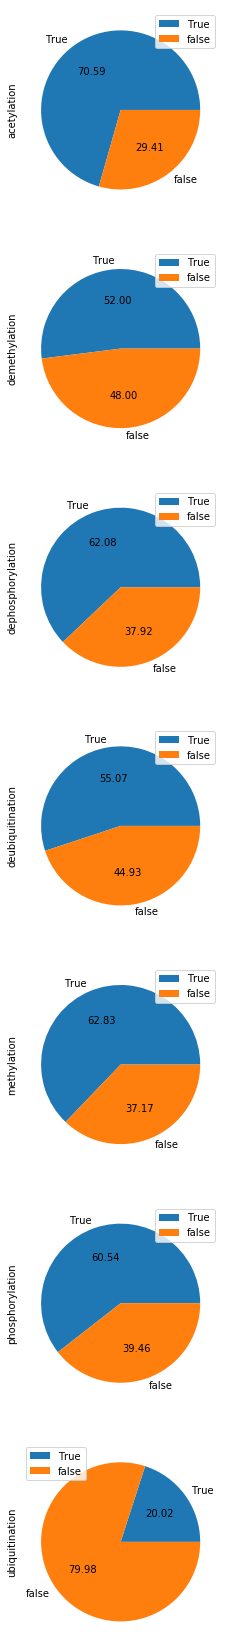

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 7,1, figsize=(45,30))
train.groupby(['isNegative', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

In [17]:
train.to_json("train.json")
test.to_json("test.json")
val.to_json("val.json")